In [88]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from math import pi as PI
from mlxtend.evaluate import bias_variance_decomp


In [48]:
# function of get_natural_cubic_spline_model
def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float 
        Minimum of interval containing the knots.
    maxval: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """
    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p

class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self
class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.  

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float 
        Minimum of interval containing the knots.
    max: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    """
    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names
    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

#### Temp

In [145]:
# create dataset
# rng = np.random.RandomState(123)
# X = np.linspace(0, 2, num = 500)
# eps = np.random.normal(0, 1, 500)
# y = np.sin(PI*X) + eps
# y[::5] += 3 * (0.5 - rng.rand(16))

In [146]:
# x_train, x_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size = 0.2,
#                                                     random_state = 1)

In [147]:
# plt.scatter(x_train, y_train, label = "Train set")
# plt.scatter(x_test, y_test, label = "Test set")
# plt.xlabel("X")
# plt.ylabel("y")
# plt.title("y = sin(πx) + Ɛ")
# plt.legend()
# plt.show()

#### Decision Tree Regressor

In [135]:
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)

In [137]:
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [138]:
# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
pred1 = regr_1.predict(X_test)
pred2 = regr_2.predict(X_test)

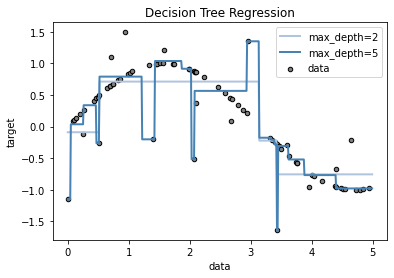

In [139]:
# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="grey", label="data")
plt.plot(X_test, pred1, color='lightsteelblue', label="max_depth=2", linewidth=2)
plt.plot(X_test, pred2, color="steelblue", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [140]:
# Reg1
extracted_MSEs = regr_1.tree_.impurity
for idx, MSE in enumerate(regr_1.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 0.5495569396281711
Node 1 has MSE 0.26795141403977085
Node 2 has MSE 0.23101631238172113
Node 3 has MSE 0.16077342308192832
Node 4 has MSE 0.14248349892568896
Node 5 has MSE 0.0018941139189612224
Node 6 has MSE 0.1223142140176402


In [141]:
# Reg2
extracted_MSEs = regr_2.tree_.impurity
for idx, MSE in enumerate(regr_1.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 0.5495569396281711
Node 1 has MSE 0.26795141403977085
Node 2 has MSE 0.23101631238172113
Node 3 has MSE 0.16077342308192832
Node 4 has MSE 0.14248349892568896
Node 5 has MSE 0.0018941139189612224
Node 6 has MSE 0.1223142140176402


In [142]:
# Reg 1
Variance_1 = np.var(pred1)
SSE_1 = np.mean((np.mean(pred1) - y)**2)
Bias_1 = SSE_1 - Variance_1
print('Variance:', Variance_1)
print('Bias:', Bias_1)

Variance: 0.43575212619106773
Bias: 0.11143766916187303


In [143]:
# Reg 2
Variance_2 = np.var(pred2)
SSE_2 = np.mean((np.mean(pred2) - y)**2)
Bias_2 = SSE_2 - Variance_2
print('Variance:', Variance_2)
print('Bias:', Bias_2)

Variance: 0.552493796284432
Bias: -0.005359218142788835


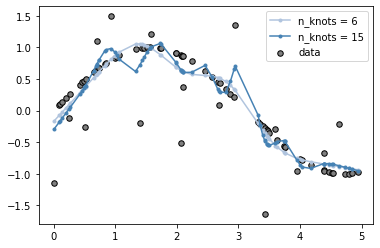

In [144]:
# natural spline
model_6 = get_natural_cubic_spline_model(X, y, minval = min(X), maxval = max(X), n_knots = 6)
model_15 = get_natural_cubic_spline_model(X, y, minval=min(X), maxval=max(X), n_knots=15)

y_est_6 = model_6.predict(X)
y_est_15 = model_15.predict(X)
plt.scatter(X, y, s=30, edgecolor="black", c="grey", label="data")
plt.plot(X, y_est_6, marker='.', label='n_knots = 6', color='lightsteelblue')
plt.plot(X, y_est_15, marker='.', label='n_knots = 15', color="steelblue")
plt.legend(); plt.show()